In [1]:
# -- Imports -- #

import numpy as np                                  # Opérations numériques
import pandas as pd                                 # Manipulation de tableaux
import matplotlib.pyplot as plt                       # Graphiques
import seaborn as sns                                 # Graphiques avancés
import sys
import os
import time
import shap
import mlflow
import mlflow.sklearn
import lightgbm as lgb
from pathlib import Path

# Ajout de la racine du projet
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

# On ajoute le dossier src/
src_path = os.path.abspath(os.path.join(project_root, "src"))
sys.path.append(src_path)

from src.data_loader import load_all_data
from src.preprocessing.preprocess import Preprocessor
from src.preprocessing.feature_engineering import FeatureEngineer
from src.config.config import config
from src.utils.timer import timer
from lightgbm import LGBMClassifier                         

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold # Splitage, Validation croisée et recherche d'hyperparamètres
from sklearn.metrics import confusion_matrix, roc_auc_score, make_scorer, roc_curve  # Métriques de performance de modèle
from sklearn.dummy import DummyClassifier             # Baseline
from sklearn.linear_model import LogisticRegression  
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# PARTIE 1 – Chargement des données 

In [2]:
# Chargement des données
data = load_all_data()

# Récupération des datasets train et test
train = data["train"]
test  = data["test"]

[--] Chargement de tous les fichiers CSV terminé en 15.29 sec [--]



In [3]:
# Affichage des premières lignes du jeu de données d'entraînement
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Affichage des informations sur le jeu de données d'entraînement
train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [5]:
# Vérification des valeurs manquantes dans le jeu de données d'entraînement
train.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

In [6]:
# Affichage des premières lignes du jeu de données de test
test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Affichage des informations sur le jeu de données de test
test.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,48744.000000,48744.000000,48744.000000,48744.000000,...,48744.000000,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000
mean,277796.676350,0.397054,1.784318e+05,5.167404e+05,29426.240209,4.626188e+05,0.021226,-16068.084605,67485.366322,-4967.652716,...,0.001559,0.0,0.0,0.0,0.002108,0.001803,0.002787,0.009299,0.546902,1.983769
std,103169.547296,0.709047,1.015226e+05,3.653970e+05,16016.368315,3.367102e+05,0.014428,4325.900393,144348.507136,3552.612035,...,0.039456,0.0,0.0,0.0,0.046373,0.046132,0.054037,0.110924,0.693305,1.838873
min,100001.000000,0.000000,2.694150e+04,4.500000e+04,2295.000000,4.500000e+04,0.000253,-25195.000000,-17463.000000,-23722.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,188557.750000,0.000000,1.125000e+05,2.606400e+05,17973.000000,2.250000e+05,0.010006,-19637.000000,-2910.000000,-7459.250000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,277549.000000,0.000000,1.575000e+05,4.500000e+05,26199.000000,3.960000e+05,0.018850,-15785.000000,-1293.000000,-4490.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,367555.500000,1.000000,2.250000e+05,6.750000e+05,37390.500000,6.300000e+05,0.028663,-12496.000000,-296.000000,-1901.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
max,456250.000000,20.000000,4.410000e+06,2.245500e+06,180576.000000,2.245500e+06,0.072508,-7338.000000,365243.000000,0.000000,...,1.000000,0.0,0.0,0.0,2.000000,2.000000,2.000000,6.000000,7.000000,17.000000


In [8]:
# Vérification des valeurs manquantes dans le jeu de données de test
test.isnull().sum()

SK_ID_CURR                       0
NAME_CONTRACT_TYPE               0
CODE_GENDER                      0
FLAG_OWN_CAR                     0
FLAG_OWN_REALTY                  0
                              ... 
AMT_REQ_CREDIT_BUREAU_DAY     6049
AMT_REQ_CREDIT_BUREAU_WEEK    6049
AMT_REQ_CREDIT_BUREAU_MON     6049
AMT_REQ_CREDIT_BUREAU_QRT     6049
AMT_REQ_CREDIT_BUREAU_YEAR    6049
Length: 121, dtype: int64

##### Notes : Pas mal de valeurs manquantes présentes dans les deux datasets. On va devoir les gérer lors de la phase de préprocessing.

# PARTIE 2 – Feature Engineering et Analyse exploratoire

In [9]:
# Feature Engineering CROSS-TABLE (Agrégation, Transformations et merge de toutes les tables)
fe = FeatureEngineer()
train_fe, test_fe = fe.merge_all(data)

# Preprocessing complet (imputation, encodage, scaling, etc.)
# pp = Preprocessor()
# train_clean = pp.transform(train_fe)
# test_clean  = pp.transform(test_fe)

# --- Preprocessing (Correct, sans fuite de données) ---

# 1. Initialiser le preprocessor
pp = Preprocessor()

# 2. Apprendre les transformations UNIQUEMENT sur le jeu d'entraînement
pp.fit(train_fe)

# 3. Appliquer ces transformations apprises sur les deux jeux de données
train_clean = pp.transform(train_fe)
test_clean  = pp.transform(test_fe)

print("Preprocessing terminé.")
print(f"Dimensions après preprocessing : train={train_clean.shape}, test={test_clean.shape}")

# Assurer la cohérence des colonnes (double-vérification)
assert all(train_clean.columns == test_clean.columns)


# train_clean.head()

[--] FE bureau + bureau_balance terminé en 1.88 sec [--]

[--] FE previous_application terminé en 1.12 sec [--]

[--] FE installments terminé en 2.88 sec [--]

[--] FE POS terminé en 1.63 sec [--]

[--] FE credit terminé en 2.28 sec [--]

[--] Feature Engineering global terminé en 12.14 sec [--]

[--] Fitting Preprocessor terminé en 2.60 sec [--]

[--] Transforming data terminé en 2.09 sec [--]

[--] Transforming data terminé en 0.26 sec [--]

Preprocessing terminé.
Dimensions après preprocessing : train=(307511, 520), test=(48744, 520)


In [10]:
# Vérification des valeurs manquantes dans le jeu de données d'entraînement après preprocessing
train_clean.isnull().sum()

SK_ID_CURR                         0
TARGET                             0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
                                  ..
WALLSMATERIAL_MODE_Stone, brick    0
WALLSMATERIAL_MODE_Unknown         0
WALLSMATERIAL_MODE_Wooden          0
EMERGENCYSTATE_MODE_Unknown        0
EMERGENCYSTATE_MODE_Yes            0
Length: 520, dtype: int64

In [11]:
# Vérification des valeurs manquantes dans le jeu de données de test après preprocessing
test_clean.isnull().sum()

SK_ID_CURR                         0
TARGET                             0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
                                  ..
WALLSMATERIAL_MODE_Stone, brick    0
WALLSMATERIAL_MODE_Unknown         0
WALLSMATERIAL_MODE_Wooden          0
EMERGENCYSTATE_MODE_Unknown        0
EMERGENCYSTATE_MODE_Yes            0
Length: 520, dtype: int64

##### Notes : Les valeurs manquantes ont bien été gérées lors du preprocessing.

In [12]:
# séparation de la target et des features
y = train_clean["TARGET"]
X = train_clean.drop(columns=["TARGET"])

In [13]:
# Sélection  de features avec SelectKBest (ANOVA)
# Retirer les features à variance nulle
vt = VarianceThreshold()
vt.fit(X)
mask = vt.get_support()
X_filtered = X.loc[:, mask]

# Application de SelectKBest avec ANOVA
selector_kbest = SelectKBest(score_func=f_classif, k=50)
selector_kbest.fit(X_filtered, y)
features_kbest = X_filtered.columns[selector_kbest.get_support()].tolist()

print("\n - Features sélectionnées par SelectKBest (ANOVA) : {} \n".format(len(features_kbest)))
display(features_kbest)


 - Features sélectionnées par SelectKBest (ANOVA) : 50 



['DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'FLAG_EMP_PHONE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'bureau_DAYS_CREDIT_mean',
 'bureau_DAYS_CREDIT_min',
 'bureau_DAYS_CREDIT_max',
 'bureau_DAYS_CREDIT_ENDDATE_mean',
 'bureau_DAYS_CREDIT_ENDDATE_sum',
 'bureau_DAYS_ENDDATE_FACT_mean',
 'bureau_DAYS_ENDDATE_FACT_min',
 'bureau_DAYS_ENDDATE_FACT_sum',
 'bureau_DAYS_CREDIT_UPDATE_mean',
 'bureau_bb_MONTHS_BALANCE_mean_mean',
 'bureau_bb_MONTHS_BALANCE_min_mean',
 'prev_DAYS_DECISION_mean',
 'prev_DAYS_DECISION_min',
 'prev_DAYS_FIRST_DRAWING_min',
 'prev_DAYS_FIRST_DUE_min',
 'prev_DAYS_LAST_DUE_1ST_VERSION_min',
 'prev_DAYS_LAST_DUE_min',
 'prev_DAYS_TERMINATION_min',
 'ins_DAYS_INSTALMENT_mean',
 'ins_DAYS_INSTALMENT_min',
 'ins_DAYS_ENTRY_PAYMENT_mean',
 'ins_DAYS_ENTRY_PAYMENT_min',
 'pos_MONTHS_BALANCE_mi

In [14]:
# Sélection  de features avec SelectKBest (mutual info)
selector_mi = SelectKBest(score_func=mutual_info_classif, k=50)
selector_mi.fit(X_filtered, y)
features_mi = X_filtered.columns[selector_mi.get_support()].tolist()

print("\n - Features sélectionnées par SelectKBest (mutual info) : {} \n".format(len(features_mi)))
display(features_mi)


 - Features sélectionnées par SelectKBest (mutual info) : 50 



['FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_CONT_MOBILE',
 'COMMONAREA_MODE',
 'COMMONAREA_MEDI',
 'FLAG_DOCUMENT_3',
 'bureau_bb_MONTHS_BALANCE_sum_min',
 'prev_NFLAG_LAST_APPL_IN_DAY_mean',
 'prev_NFLAG_LAST_APPL_IN_DAY_min',
 'prev_NFLAG_LAST_APPL_IN_DAY_max',
 'prev_RATE_INTEREST_PRIMARY_mean',
 'prev_RATE_INTEREST_PRIMARY_min',
 'prev_RATE_INTEREST_PRIMARY_max',
 'prev_RATE_INTEREST_PRIVILEGED_mean',
 'prev_RATE_INTEREST_PRIVILEGED_min',
 'prev_RATE_INTEREST_PRIVILEGED_max',
 'prev_DAYS_FIRST_DRAWING_mean',
 'prev_DAYS_FIRST_DRAWING_min',
 'prev_DAYS_FIRST_DRAWING_max',
 'prev_NFLAG_INSURED_ON_APPROVAL_max',
 'ins_NUM_INSTALMENT_VERSION_min',
 'ins_NUM_INSTALMENT_NUMBER_min',
 'cc_MONTHS_BALANCE_mean',
 'cc_MONTHS_BALANCE_min',
 'cc_MONTHS_BALANCE_max',
 'cc_AMT_CREDIT_LIMIT_ACTUAL_mean',
 'cc_AMT_CREDIT_LIMIT_ACTUAL_max',
 'cc_AMT_CREDIT_LIMIT_ACTUAL_sum',
 'cc_AMT_DRAWINGS_ATM_CURRENT_mean',
 'cc_AMT_DRAWINGS_ATM_CURRENT_max',
 'cc_AMT_DRAWINGS_ATM_CURRENT_sum',
 'cc_AMT_DRAWINGS_C

In [15]:
# Sélection de features avec LightGBM importance (Top 50 des features avec plus haute importance 
# pour rester cohérent avec les tests ANOVA et mutual info)

# Nettoyage des noms de colonnes sur X_filtered
X_filtered.columns = X_filtered.columns.str.replace(r'[^\w]', '_', regex=True)  

model_lgb = lgb.LGBMClassifier(n_estimators=200)
model_lgb.fit(X_filtered, y)
importance_df = pd.DataFrame({
    "feature": X_filtered.columns,
    "importance": model_lgb.feature_importances_
}).sort_values("importance", ascending=False)
features_lgb = importance_df.head(50)["feature"].tolist()

selected_features = list(set(features_kbest + features_mi + features_lgb))

[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.225955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 69881
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 510
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486


In [16]:
# Affichage des features sélectionnées
print("\n - Features sélectionnées par LightGBM importance : {} \n".format(len(selected_features)))
display(selected_features)


 - Features sélectionnées par LightGBM importance : 130 



['bureau_DAYS_CREDIT_UPDATE_mean',
 'bureau_DAYS_CREDIT_ENDDATE_sum',
 'cc_CNT_INSTALMENT_MATURE_CUM_sum',
 'REG_CITY_NOT_LIVE_CITY',
 'prev_RATE_INTEREST_PRIMARY_max',
 'COMMONAREA_MODE',
 'bureau_DAYS_ENDDATE_FACT_mean',
 'FLAG_MOBIL',
 'DAYS_ID_PUBLISH',
 'ins_DAYS_ENTRY_PAYMENT_max',
 'ins_NUM_INSTALMENT_NUMBER_min',
 'FLAG_CONT_MOBILE',
 'WALLSMATERIAL_MODE_Unknown',
 'cc_AMT_DRAWINGS_ATM_CURRENT_mean',
 'ins_NUM_INSTALMENT_NUMBER_max',
 'bureau_DAYS_CREDIT_UPDATE_max',
 'cc_AMT_RECEIVABLE_PRINCIPAL_mean',
 'bureau_bb_MONTHS_BALANCE_sum_min',
 'ins_NUM_INSTALMENT_VERSION_sum',
 'cc_AMT_PAYMENT_CURRENT_mean',
 'NAME_FAMILY_STATUS_Married',
 'prev_DAYS_LAST_DUE_min',
 'NAME_HOUSING_TYPE_House / apartment',
 'AMT_ANNUITY',
 'bureau_DAYS_ENDDATE_FACT_min',
 'NAME_EDUCATION_TYPE_Higher education',
 'bureau_DAYS_CREDIT_min',
 'NAME_INCOME_TYPE_Working',
 'pos_MONTHS_BALANCE_min',
 'cc_CNT_DRAWINGS_ATM_CURRENT_mean',
 'prev_DAYS_FIRST_DRAWING_mean',
 'FLAG_EMP_PHONE',
 'FLAG_DOCUMENT_3',

##### Notes : Le top 50 de LightGBM importance ci-dessus montre une cohérence avec les autres méthodes de sélection de features. Basons nous dessus et gérons la multicolinéarité.

In [17]:
# Supprimer les features trop corrélées (>0.8) pour éviter la multicolinéarité
def remove_highly_correlated_features(df, threshold=0.8):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] >= threshold)]
    return df.drop(columns=to_drop)

# Appliquer sur train_clean[selected_features]
df_selected = train_clean[selected_features]
df_selected_clean = remove_highly_correlated_features(df_selected)
selected_features = df_selected_clean.columns.tolist()

print(f"Features après suppression des corrélées : {len(selected_features)}")

Features après suppression des corrélées : 92


In [18]:
# Construction de df_final
df_final = train_clean[selected_features + ["TARGET"]].copy()
df_final.columns = df_final.columns.str.replace(" ", "_")

df_final.fillna(df_final.median(), inplace=True)

print(f"Total features sélectionnées : {len(selected_features)}")
print(f"Dataset shape: {df_final.shape}")
df_final.head()

Total features sélectionnées : 92
Dataset shape: (307511, 93)


,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_ENDDATE_sum,cc_CNT_INSTALMENT_MATURE_CUM_sum,REG_CITY_NOT_LIVE_CITY,prev_RATE_INTEREST_PRIMARY_max,COMMONAREA_MODE,bureau_DAYS_ENDDATE_FACT_mean,FLAG_MOBIL,DAYS_ID_PUBLISH,ins_DAYS_ENTRY_PAYMENT_max,...,prev_AMT_ANNUITY_min,prev_HOUR_APPR_PROCESS_START_mean,prev_DAYS_FIRST_DRAWING_max,bureau_SK_ID_BUREAU_sum,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_DAYS_CREDIT_ENDDATE_mean,cc_AMT_DRAWINGS_POS_CURRENT_max,prev_NFLAG_INSURED_ON_APPROVAL_max,TARGET
0,-499.875000,-2094.000000,719.15838,0,0.190258,0.014400,-697.500000,1,-2120,-49.0,...,9251.775,9.000000,-1247.994783,4.922618e+07,1681.029000,245781.000000,-349.000000,43479.993213,0.0,1
1,-816.000000,-2178.000000,719.15838,0,0.190258,0.049700,-1097.333333,1,-291,-544.0,...,6737.310,14.666667,-1247.994783,2.354351e+07,0.000000,0.000000,-544.500000,43479.993213,1.0,0
2,-532.000000,-977.000000,719.15838,0,0.190258,0.042553,-532.500000,1,-2531,-727.0,...,5357.250,5.000000,-1247.994783,1.365827e+07,0.000000,0.000000,-488.500000,43479.993213,0.0,0
3,-546.632499,2575.654736,0.00000,0,0.190258,0.042553,-970.304531,1,-2437,-12.0,...,2482.920,14.666667,-1247.994783,3.275726e+07,5242.425046,640650.256634,651.807511,43479.993213,0.0,0
4,-783.000000,-783.000000,719.15838,0,0.190258,0.042553,-783.000000,1,-3458,-14.0,...,1834.290,12.333333,-1247.994783,5.987200e+06,0.000000,0.000000,-783.000000,43479.993213,1.0,0


[|] Statistiques descriptives...

,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_ENDDATE_sum,cc_CNT_INSTALMENT_MATURE_CUM_sum,REG_CITY_NOT_LIVE_CITY,prev_RATE_INTEREST_PRIMARY_max,COMMONAREA_MODE,bureau_DAYS_ENDDATE_FACT_mean,FLAG_MOBIL,DAYS_ID_PUBLISH,ins_DAYS_ENTRY_PAYMENT_max,...,prev_AMT_ANNUITY_min,prev_HOUR_APPR_PROCESS_START_mean,prev_DAYS_FIRST_DRAWING_max,bureau_SK_ID_BUREAU_sum,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_DAYS_CREDIT_ENDDATE_mean,cc_AMT_DRAWINGS_POS_CURRENT_max,prev_NFLAG_INSURED_ON_APPROVAL_max,TARGET
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,3.075110e+05,307511.000000,3.075110e+05,307511.000000,307511.000000
mean,-546.632499,2575.654736,719.158380,0.078173,0.190258,0.042553,-970.304531,0.999997,-2994.202373,-327.784607,...,7864.303564,12.661586,-1247.994783,3.275726e+07,5.242425e+03,6.406503e+05,651.807511,4.347999e+04,0.529038,0.080729
std,420.017246,11635.195373,661.331002,0.268444,0.011279,0.040861,463.588827,0.001803,1509.450419,522.825932,...,7279.823701,2.700297,101.662223,2.416281e+07,2.369431e+05,1.512496e+06,3024.768910,3.690737e+04,0.484536,0.272419
min,-41890.000000,-155271.000000,0.000000,0.000000,0.034781,0.000000,-8376.500000,0.000000,-7197.000000,-3071.000000,...,0.000000,0.000000,-2922.000000,5.000005e+06,0.000000e+00,-6.981558e+06,-41875.000000,0.000000e+00,0.000000,0.000000
25%,-721.000000,-2331.000000,719.158380,0.000000,0.190258,0.042553,-1158.000000,1.000000,-4299.000000,-359.000000,...,3633.345000,11.000000,-1247.994783,1.582919e+07,0.000000e+00,0.000000e+00,-594.500000,4.347999e+04,0.000000,0.000000
50%,-546.632499,104.000000,719.158380,0.000000,0.190258,0.042553,-970.304531,1.000000,-3254.000000,-85.000000,...,6073.380000,12.661586,-1247.994783,3.130161e+07,4.346438e+03,2.777082e+05,59.333333,4.347999e+04,0.529038,0.000000
75%,-256.000000,2575.654736,719.158380,0.000000,0.190258,0.042553,-699.354167,1.000000,-1720.000000,-27.000000,...,9150.345000,14.363636,-1247.994783,4.037655e+07,5.242425e+03,6.406503e+05,651.807511,4.347999e+04,1.000000,0.000000
max,14.000000,214193.000000,8124.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,...,300425.445000,23.000000,-2.000000,7.821227e+08,1.159872e+08,3.344983e+08,31198.000000,2.060030e+06,1.000000,1.000000



 - Pourcentage de valeurs manquantes (top 20) :


bureau_DAYS_CREDIT_UPDATE_mean       0.0
DAYS_EMPLOYED                        0.0
pos_CNT_INSTALMENT_FUTURE_mean       0.0
cc_AMT_PAYMENT_TOTAL_CURRENT_sum     0.0
prev_NFLAG_LAST_APPL_IN_DAY_mean     0.0
EXT_SOURCE_1                         0.0
bureau_AMT_CREDIT_SUM_DEBT_mean      0.0
NAME_TYPE_SUITE_Unaccompanied        0.0
ins_AMT_PAYMENT_sum                  0.0
CODE_GENDER_M                        0.0
cc_CNT_DRAWINGS_POS_CURRENT_max      0.0
cc_AMT_DRAWINGS_ATM_CURRENT_sum      0.0
DAYS_BIRTH                           0.0
bureau_DAYS_ENDDATE_FACT_max         0.0
cc_AMT_CREDIT_LIMIT_ACTUAL_max       0.0
AMT_CREDIT                           0.0
cc_AMT_CREDIT_LIMIT_ACTUAL_sum       0.0
DAYS_LAST_PHONE_CHANGE               0.0
prev_RATE_INTEREST_PRIVILEGED_max    0.0
prev_SELLERPLACE_AREA_mean           0.0
dtype: float64


 - Distribution de TARGET :
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64
[-] Statistiques descriptives...

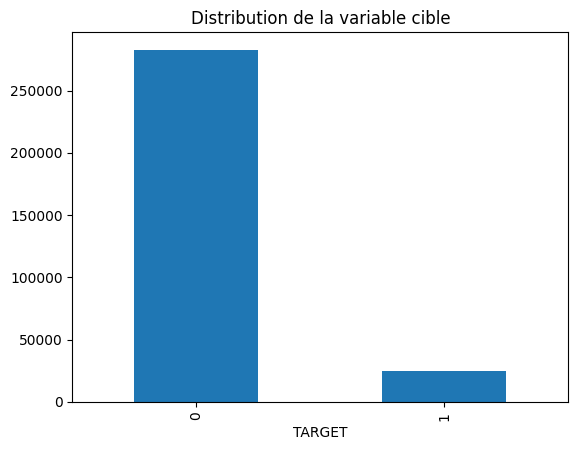

[--] Statistiques descriptives terminé en 0.66 sec [--]



In [19]:
# STATISTIQUES DESCRIPTIVES #

with timer("Statistiques descriptives"):

    # Affiche les statistiques générales des colonnes numériques
    display(df_final.describe())

    # Calcul des pourcentages de valeurs manquantes
    missing_rate = df_final.isnull().mean().sort_values(ascending=False)
    print("\n - Pourcentage de valeurs manquantes (top 20) :")
    display(missing_rate.head(20))

    # Distribution de la target (déséquilibre des classes)
    print("\n - Distribution de TARGET :")
    print(df_final["TARGET"].value_counts(normalize=True))

    # Visualisation de la distribution de la TARGET
    df_final["TARGET"].value_counts().plot(kind="bar", title="Distribution de la variable cible")
    plt.show()

[/] Corrélations avec TARGET...
 - Top 20 corrélations positives :


TARGET                               1.000000
DAYS_BIRTH                           0.078239
DAYS_EMPLOYED                        0.070075
bureau_DAYS_CREDIT_min               0.068286
bureau_DAYS_CREDIT_UPDATE_mean       0.062550
REGION_RATING_CLIENT_W_CITY          0.060893
NAME_INCOME_TYPE_Working             0.057481
DAYS_LAST_PHONE_CHANGE               0.055218
CODE_GENDER_M                        0.054713
cc_CNT_DRAWINGS_ATM_CURRENT_mean     0.052985
DAYS_ID_PUBLISH                      0.051457
REG_CITY_NOT_WORK_CITY               0.050994
bureau_bb_MONTHS_BALANCE_min_mean    0.048954
bureau_DAYS_CREDIT_ENDDATE_sum       0.048763
cc_AMT_RECEIVABLE_PRINCIPAL_mean     0.047257
FLAG_EMP_PHONE                       0.045982
prev_DAYS_DECISION_mean              0.045900
prev_DAYS_FIRST_DRAWING_min          0.045416
bureau_DAYS_CREDIT_max               0.045176
prev_DAYS_LAST_DUE_min               0.045165
Name: TARGET, dtype: float64


 - Top 20 corrélations négatives :


prev_AMT_GOODS_PRICE_min               -0.020358
ins_AMT_PAYMENT_mean                   -0.022707
cc_CNT_INSTALMENT_MATURE_CUM_sum       -0.023262
ins_AMT_PAYMENT_sum                    -0.023890
cc_AMT_CREDIT_LIMIT_ACTUAL_sum         -0.024962
NAME_FAMILY_STATUS_Married             -0.025043
ins_AMT_PAYMENT_min                    -0.025212
prev_AMT_DOWN_PAYMENT_sum              -0.026440
NAME_HOUSING_TYPE_House_/_apartment    -0.028555
ins_NUM_INSTALMENT_VERSION_sum         -0.029464
AMT_CREDIT                             -0.030369
ins_NUM_INSTALMENT_VERSION_min         -0.031402
prev_AMT_ANNUITY_min                   -0.031570
pos_SK_ID_PREV_sum                     -0.033718
prev_HOUR_APPR_PROCESS_START_mean      -0.035188
REGION_POPULATION_RELATIVE             -0.037227
NAME_EDUCATION_TYPE_Higher_education   -0.056593
EXT_SOURCE_1                           -0.099152
EXT_SOURCE_3                           -0.157397
EXT_SOURCE_2                           -0.160303
Name: TARGET, dtype:

[\] Corrélations avec TARGET...

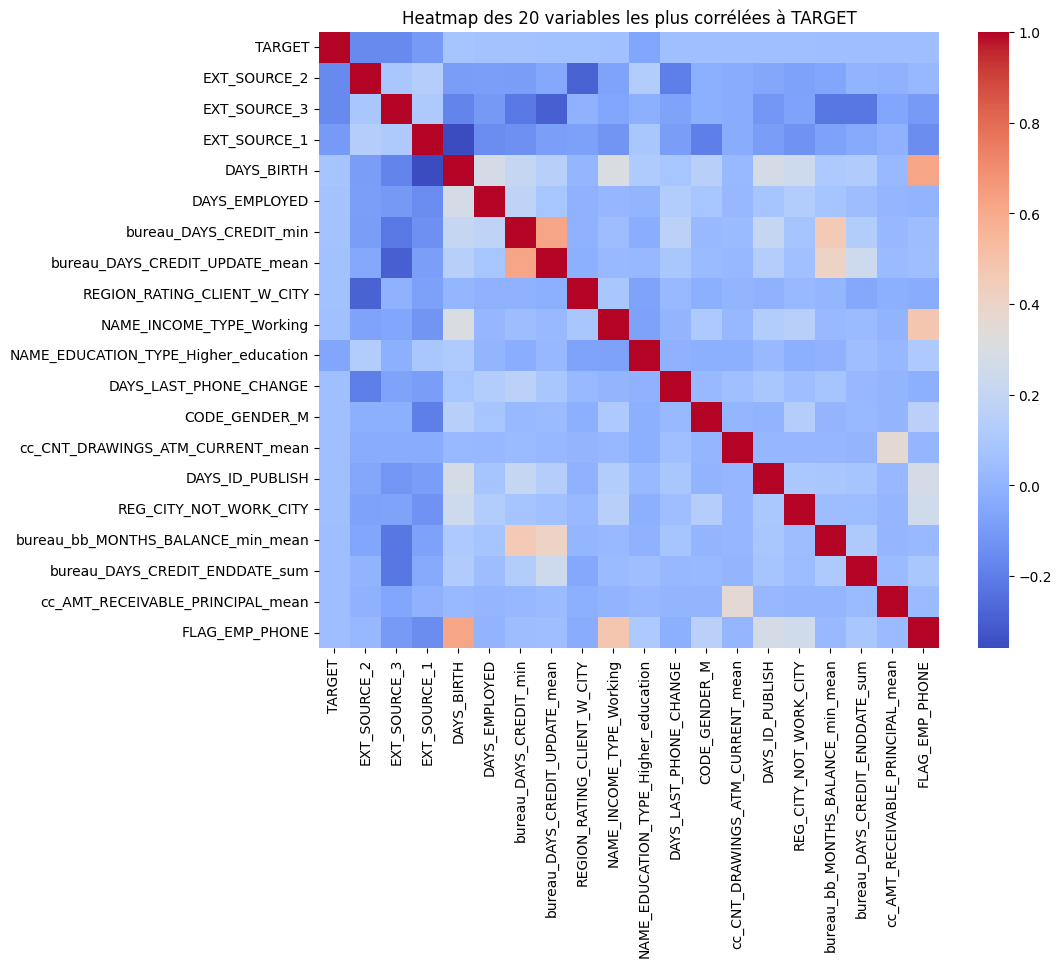

[--] Corrélations avec TARGET terminé en 2.92 sec [--]



In [20]:
# ANALYSE DES CORRÉLATIONS #

with timer("Corrélations avec TARGET"):

    # Calcul des corrélations uniquement pour les variables numériques
    corr = df_final.corr(numeric_only=True)["TARGET"].sort_values(ascending=False)

    # Affiche les 20 features les + corrélées positivement
    print("\n - Top 20 corrélations positives :")
    display(corr.head(20))

    # Affiche les 20 features les + corrélées négativement
    print("\n - Top 20 corrélations négatives :")
    display(corr.tail(20))

    # Heatmap des top variables corrélées à TARGET
    top_corr_features = corr.abs().sort_values(ascending=False).head(20).index
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_final[top_corr_features].corr(), annot=False, cmap="coolwarm")
    plt.title("Heatmap des 20 variables les plus corrélées à TARGET")
    plt.show()


[\] Visualisations de distributions...

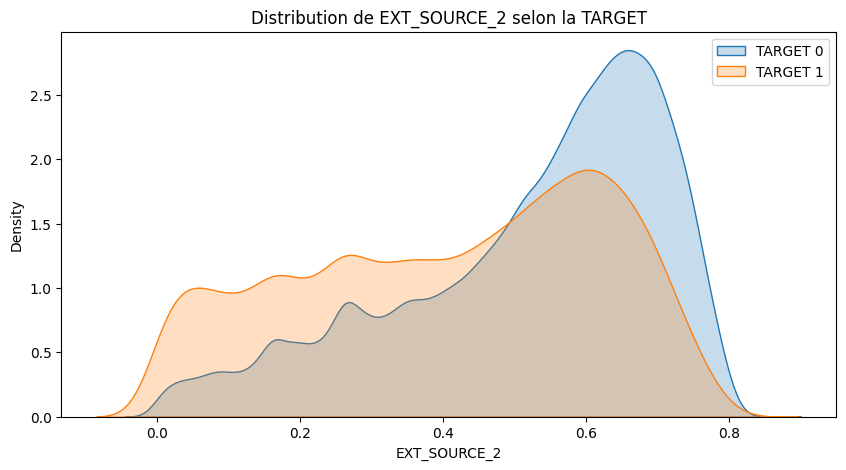

[-] Visualisations de distributions...

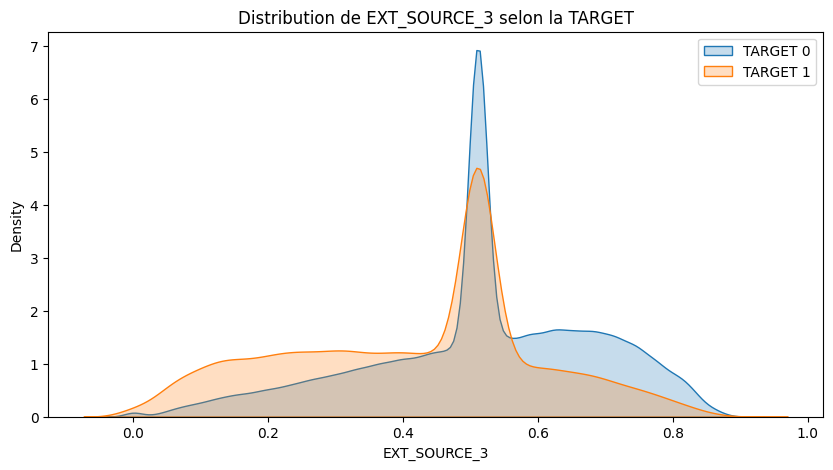

[/] Visualisations de distributions...

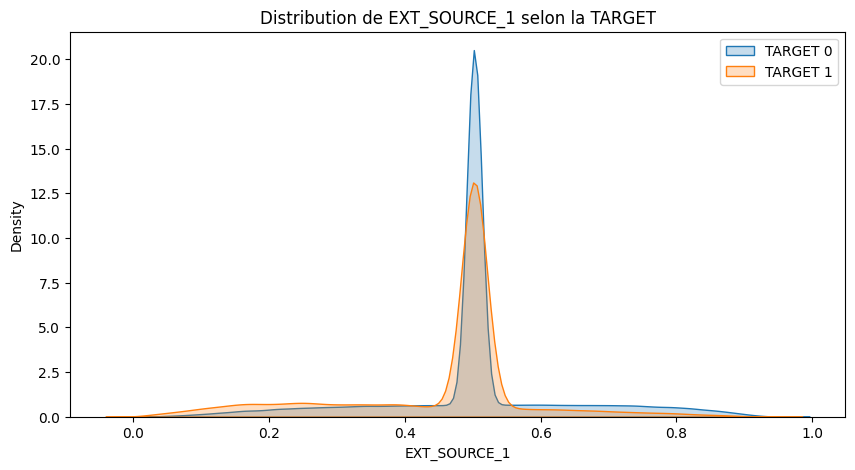

[|] Visualisations de distributions...

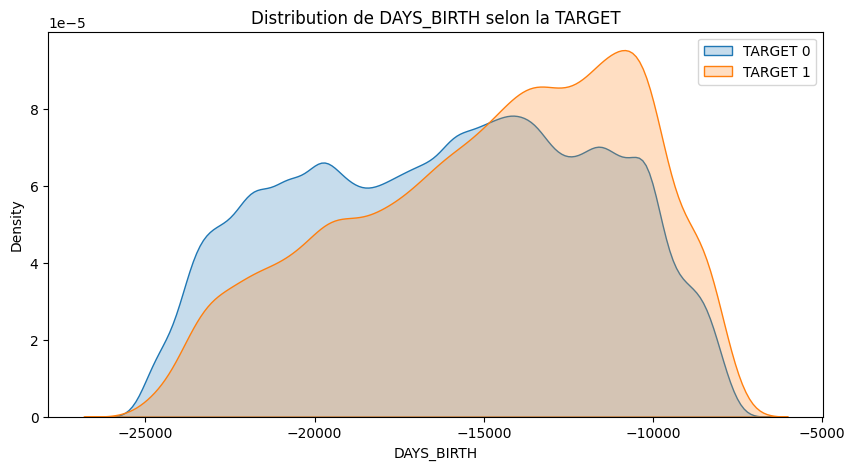

[\] Visualisations de distributions...

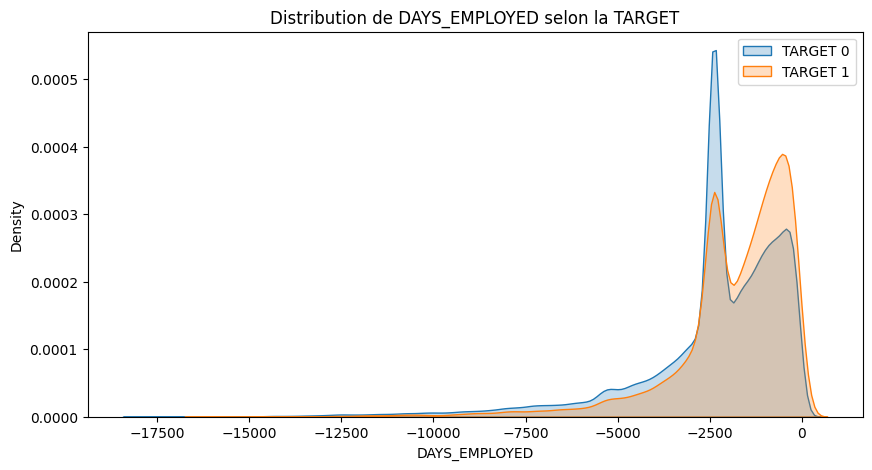

[--] Visualisations de distributions terminé en 1.86 sec [--]

[-] Boxplots des top features...

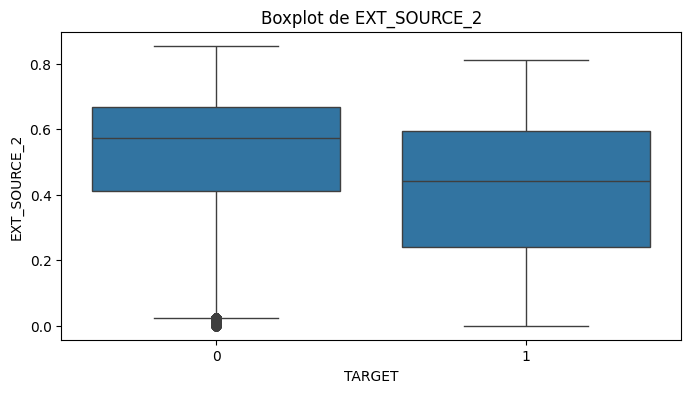

[|] Boxplots des top features...

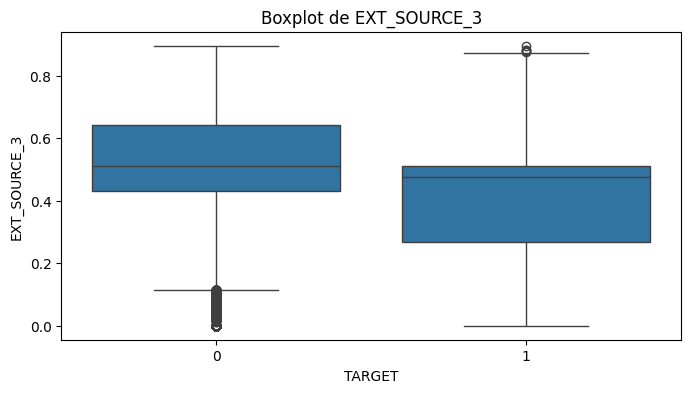

[-] Boxplots des top features...

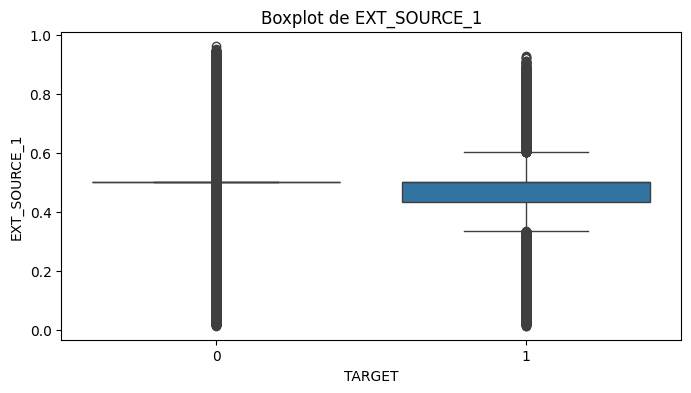

[\] Boxplots des top features...

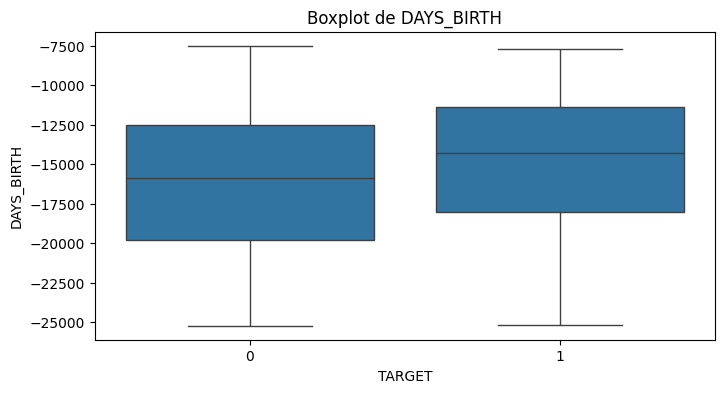

[/] Boxplots des top features...

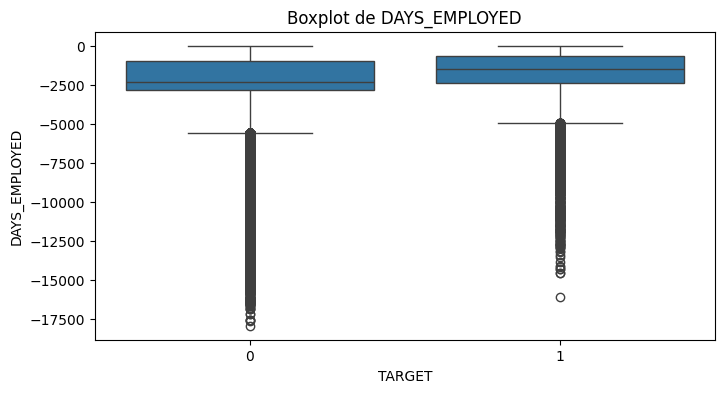

[--] Boxplots des top features terminé en 1.06 sec [--]



In [21]:
# VISUALISATIONS IMPORTANTES #

# Enlevons la taget des variables les plus corrélées
top_features = [col for col in top_corr_features if col != "TARGET"]
top_vars = top_features[:5]

with timer("Visualisations de distributions"):
    
    for col in top_vars:
        plt.figure(figsize=(10, 5))
        sns.kdeplot(df_final[df_final["TARGET"] == 0][col], label="TARGET 0", fill=True)
        sns.kdeplot(df_final[df_final["TARGET"] == 1][col], label="TARGET 1", fill=True)
        plt.title(f"Distribution de {col} selon la TARGET")
        plt.legend()
        plt.show()

with timer("Boxplots des top features"):

    for col in top_vars:
        if col != "TARGET":
            plt.figure(figsize=(8, 4))
            sns.boxplot(x="TARGET", y=col, data=df_final)
            plt.title(f"Boxplot de {col}")
            plt.show()


In [22]:
# Filtrons les features avec corrélation absolue > 0.05 (celles avec aucun lien avec notre cible)
CORR_INDICE = 0.05
selected_corr_features = corr.abs()[corr.abs() > CORR_INDICE].index.tolist()
selected_corr_features = [f for f in selected_corr_features if f != "TARGET"]

top_features = selected_corr_features
print("\n Nombre de features : {}".format(len(top_features)))
top_features


 Nombre de features : 15


['DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'bureau_DAYS_CREDIT_min',
 'bureau_DAYS_CREDIT_UPDATE_mean',
 'REGION_RATING_CLIENT_W_CITY',
 'NAME_INCOME_TYPE_Working',
 'DAYS_LAST_PHONE_CHANGE',
 'CODE_GENDER_M',
 'cc_CNT_DRAWINGS_ATM_CURRENT_mean',
 'DAYS_ID_PUBLISH',
 'REG_CITY_NOT_WORK_CITY',
 'NAME_EDUCATION_TYPE_Higher_education',
 'EXT_SOURCE_1',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2']

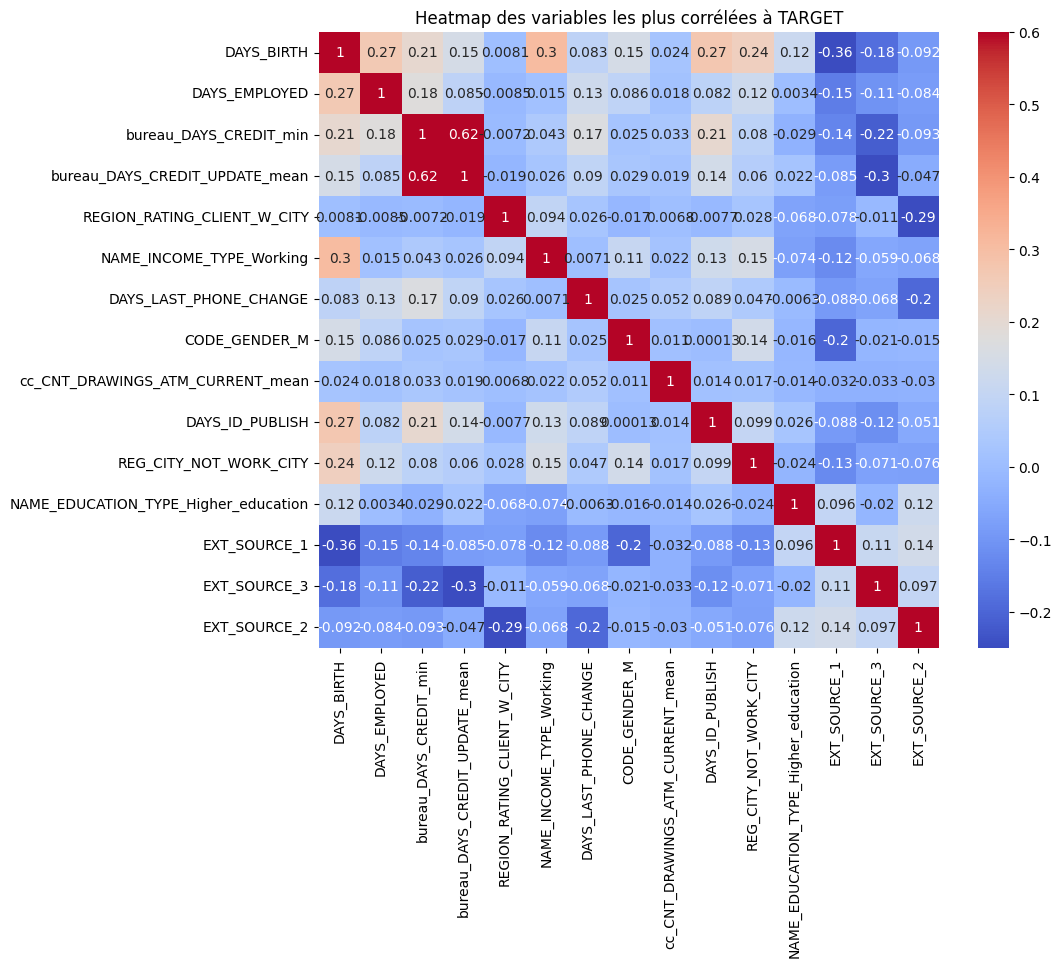

In [23]:
# Headmap des features les plus corrélées à TARGET (Pour plus de clarté)
plt.figure(figsize=(10, 8))
sns.heatmap(df_final[top_features].corr(), cmap = "coolwarm", vmin = -0.25, annot = True, vmax = 0.6)
plt.title("Heatmap des variables les plus corrélées à TARGET")
plt.show()

##### Notes : Les variables 'bureau_DAYS_CREDIT_min' et 'bureau_DAYS_CREDIT_UPDATE_mean' présentent une corrélation entre elles, mais à 0.6 nous verrons s'il faut en supprimer un par la suite.

[-] Radar Plot...

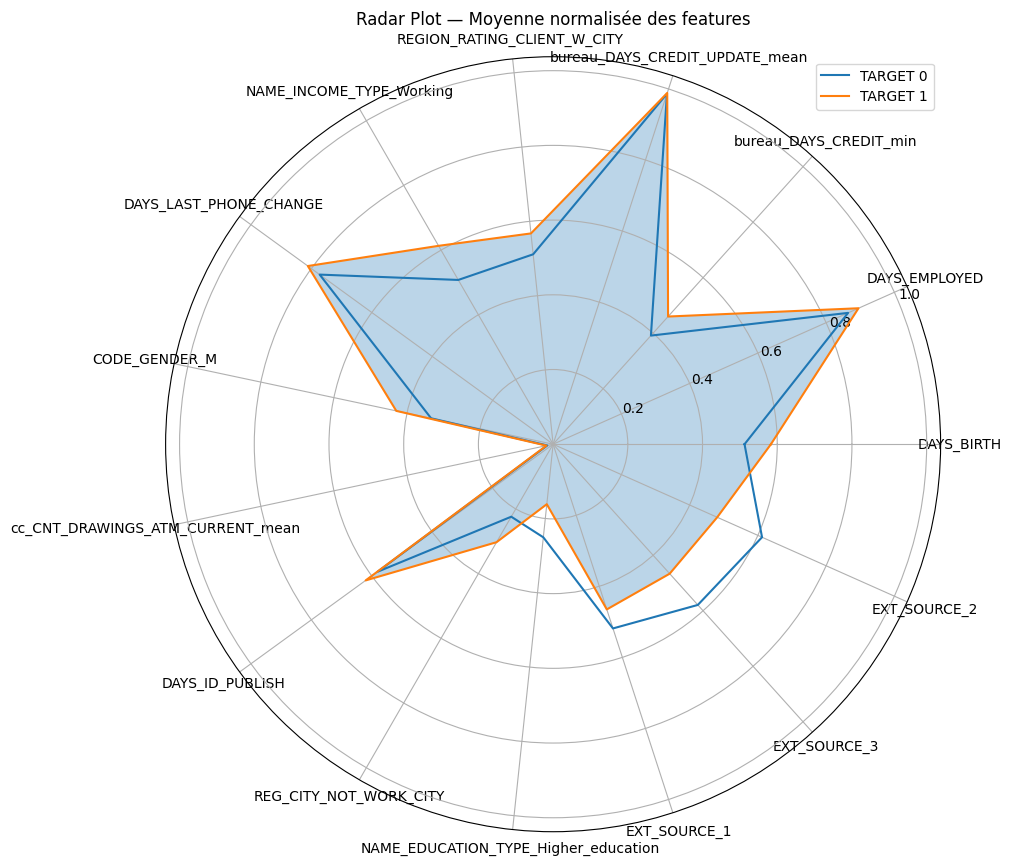

[--] Radar Plot terminé en 0.22 sec [--]



In [24]:
# Radar Plot pour comparer TARGET 0 vs TARGET 1 et identifier les variables discriminantes

with timer("Radar Plot"):

    # Sélection des top features
    radar_vars = top_features

    # Normalisation min-max
    scaler = MinMaxScaler() # pour que chaque feature soit sur une échelle comparable
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df_final[radar_vars]),
        columns=radar_vars
    )
    df_scaled["TARGET"] = df_final["TARGET"]

    # Moyennes pour chaque classe
    mean_0 = df_scaled[df_scaled["TARGET"] == 0][radar_vars].mean().values
    mean_1 = df_scaled[df_scaled["TARGET"] == 1][radar_vars].mean().values

    angles = np.linspace(0, 2 * np.pi, len(radar_vars), endpoint=False)
    mean_0 = np.concatenate((mean_0, [mean_0[0]]))
    mean_1 = np.concatenate((mean_1, [mean_1[0]]))
    angles = np.concatenate((angles, [angles[0]]))

    fig = plt.figure(figsize=(10, 11))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, mean_0, label="TARGET 0")
    ax.plot(angles, mean_1, label="TARGET 1")
    ax.fill(angles, mean_1, alpha=0.3)
    ax.set_thetagrids(angles[:-1] * 180/np.pi, radar_vars)
    plt.title("Radar Plot — Moyenne normalisée des features")
    plt.legend()
    plt.show()


In [25]:
# Supprésion des top_features pas très discriminante au vue du radar plot.
feature_remove = ["NAME_EDUCATION_TYPE_Higher_education", "cc_CNT_DRAWINGS_ATM_CURRENT_mean", 
                  "REG_CITY_NOT_WORK_CITY", "CODE_GENDER_M", "bureau_DAYS_CREDIT_min"]
for feature in feature_remove:
    if feature in top_features:
        top_features.remove(feature)

In [26]:
# Info sur les features finales
df_final[top_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 10 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   DAYS_BIRTH                      307511 non-null  int64  
 1   DAYS_EMPLOYED                   307511 non-null  float64
 2   bureau_DAYS_CREDIT_UPDATE_mean  307511 non-null  float64
 3   REGION_RATING_CLIENT_W_CITY     307511 non-null  int64  
 4   NAME_INCOME_TYPE_Working        307511 non-null  bool   
 5   DAYS_LAST_PHONE_CHANGE          307511 non-null  float64
 6   DAYS_ID_PUBLISH                 307511 non-null  int64  
 7   EXT_SOURCE_1                    307511 non-null  float64
 8   EXT_SOURCE_3                    307511 non-null  float64
 9   EXT_SOURCE_2                    307511 non-null  float64
dtypes: bool(1), float64(6), int64(3)
memory usage: 21.4 MB


[/] Radar Plot...

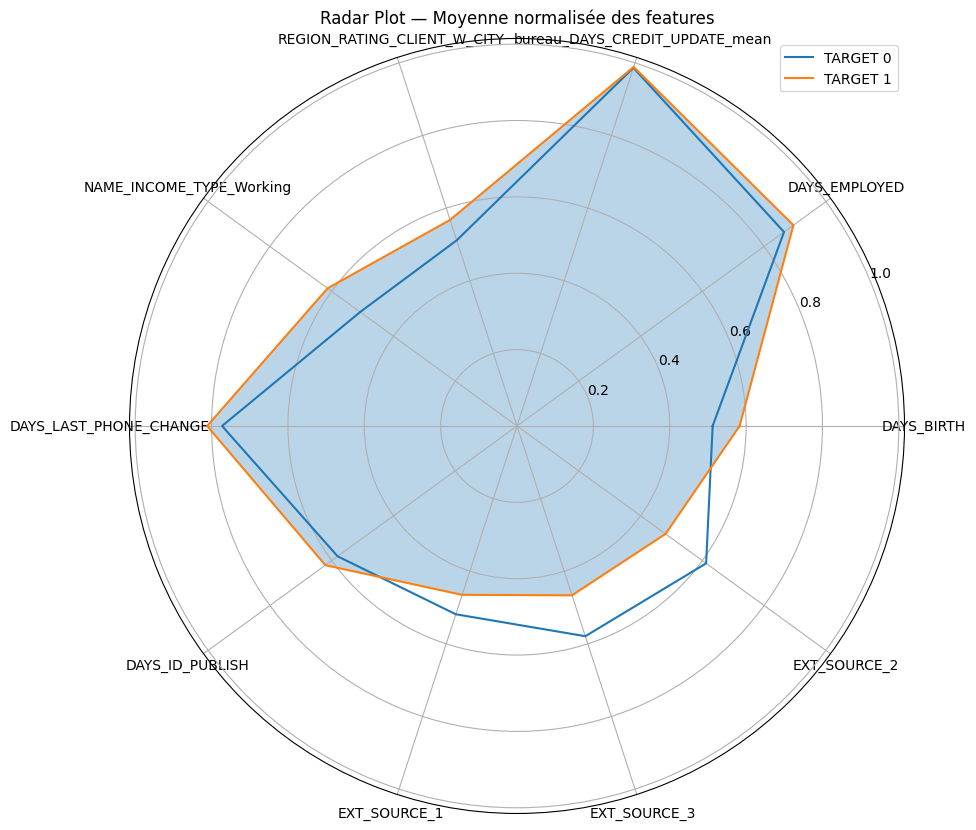

[--] Radar Plot terminé en 0.16 sec [--]



In [27]:
# Relance du Radar Plot 

with timer("Radar Plot"):

    # Sélection des top features
    radar_vars = top_features

    # Normalisation min-max
    scaler = MinMaxScaler() # pour que chaque feature soit sur une échelle comparable
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df_final[radar_vars]),
        columns=radar_vars
    )
    df_scaled["TARGET"] = df_final["TARGET"]

    # Moyennes pour chaque classe
    mean_0 = df_scaled[df_scaled["TARGET"] == 0][radar_vars].mean().values
    mean_1 = df_scaled[df_scaled["TARGET"] == 1][radar_vars].mean().values

    angles = np.linspace(0, 2 * np.pi, len(radar_vars), endpoint=False)
    mean_0 = np.concatenate((mean_0, [mean_0[0]]))
    mean_1 = np.concatenate((mean_1, [mean_1[0]]))
    angles = np.concatenate((angles, [angles[0]]))

    fig = plt.figure(figsize=(10, 11))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, mean_0, label="TARGET 0")
    ax.plot(angles, mean_1, label="TARGET 1")
    ax.fill(angles, mean_1, alpha=0.3)
    ax.set_thetagrids(angles[:-1] * 180/np.pi, radar_vars)
    plt.title("Radar Plot — Moyenne normalisée des features")
    plt.legend()
    plt.show()


##### Notes :
Au final comme le montre le radar plot nous conservons 10 features discriminantes pour le modèle entre les 2 classes TARGET 0 et 1.

##### TARGET 1 a des valeurs plus élevées pour :
- DAYS_BIRTH
- DAYS_EMPLOYED
- bureau_DAYS_CREDIT_UPDATE_mean
- REGION_RATING_CLIENT_W_CITY
- NAME_INCOME_TYPE_Working
- DAYS_LAST_PHONE_CHANGE
- DAYS_ID_PUBLISH
- pos_MONTHS_BALANCE_min

##### TARGET 0 a des valeurs plus élevées pour :
- EXT_SOURCE_1
- EXT_SOURCE_3
- EXT_SOURCE_2

# PARTIE 3 – Score métier, FN/FP, baseline

- Création d’un score métier basé sur la pondération des Faux Négatifs (FN) et Faux Positifs (FP)
- Création d’une baseline (modèle simple de référence)
- Séparation train/test
- Calcul + visualisation FN / FP
- Matrice de confusion
- Courbe ROC

In [28]:
# Création de df_final_features avec les features les plus discriminantes à la TARGET
df_final_features = df_final[top_features].copy()
df_final_features.head()

,DAYS_BIRTH,DAYS_EMPLOYED,bureau_DAYS_CREDIT_UPDATE_mean,REGION_RATING_CLIENT_W_CITY,NAME_INCOME_TYPE_Working,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,EXT_SOURCE_1,EXT_SOURCE_3,EXT_SOURCE_2
0,-9461,-637.0,-499.875000,2,True,-1134.0,-2120,0.083037,0.139376,0.262949
1,-16765,-1188.0,-816.000000,1,False,-828.0,-291,0.311267,0.510853,0.622246
2,-19046,-225.0,-532.000000,2,True,-815.0,-2531,0.502130,0.729567,0.555912
3,-19005,-3039.0,-546.632499,2,True,-617.0,-2437,0.502130,0.510853,0.650442
4,-19932,-3038.0,-783.000000,2,True,-1106.0,-3458,0.502130,0.510853,0.322738


In [29]:
# Statistiques descriptives des features finales
df_final_features.describe()

,DAYS_BIRTH,DAYS_EMPLOYED,bureau_DAYS_CREDIT_UPDATE_mean,REGION_RATING_CLIENT_W_CITY,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,EXT_SOURCE_1,EXT_SOURCE_3,EXT_SOURCE_2
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,3.075110e+05
mean,-16036.995067,-2384.169325,-546.632499,2.031521,-962.858788,-2994.202373,0.502130,0.510853,5.143927e-01
std,4363.988632,2117.381973,420.017246,0.502737,826.807143,1509.450419,0.139395,0.174464,1.908550e-01
min,-25229.000000,-17912.000000,-41890.000000,1.000000,-4292.000000,-7197.000000,0.014568,0.000527,8.173617e-08
25%,-19682.000000,-2760.000000,-721.000000,2.000000,-1570.000000,-4299.000000,0.502130,0.417100,3.929737e-01
50%,-15750.000000,-2219.000000,-546.632499,2.000000,-757.000000,-3254.000000,0.502130,0.510853,5.654672e-01
75%,-12413.000000,-933.000000,-256.000000,2.000000,-274.000000,-1720.000000,0.502130,0.636376,6.634218e-01
max,-7489.000000,0.000000,14.000000,3.000000,0.000000,0.000000,0.962693,0.896010,8.549997e-01


In [30]:
# -- Séparation X / y -- #
X = df_final_features
y = df_final['TARGET']

# Train / Test interne (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

In [31]:
# -- Création d'une baseline -- #

# DummyClassifier prédit toujours la classe majoritaire
baseline = DummyClassifier(strategy="most_frequent")

# Entraînement sur le train interne
baseline.fit(X_train, y_train)

# Prédiction sur le test interne
y_pred_baseline = baseline.predict(X_test)

# Calcul du score ROC AUC 
auc_baseline = roc_auc_score(y_test, y_pred_baseline)

print(f"Baseline ROC AUC : {auc_baseline:.4f}")

Baseline ROC AUC : 0.5000


In [32]:
# -- Matrice de confusion baseline -- #

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred_baseline)

# On extrait les éléments de la matrice
TN = cm[0, 0]    # True Negative : bon client correctement classé
FP = cm[0, 1]    # Faux Positif  : bon client considéré à tort comme mauvais
FN = cm[1, 0]    # Faux Négatif  : mauvais client considéré à tort comme bon (GRAVE!)
TP = cm[1, 1]    # True Positive : mauvais client bien détecté

print("Matrice de confusion baseline :")
print(cm)

print(f"\nFN : {FN}  |  FP : {FP}")

Matrice de confusion baseline :
[[56538     0]
 [ 4965     0]]

FN : 4965  |  FP : 0


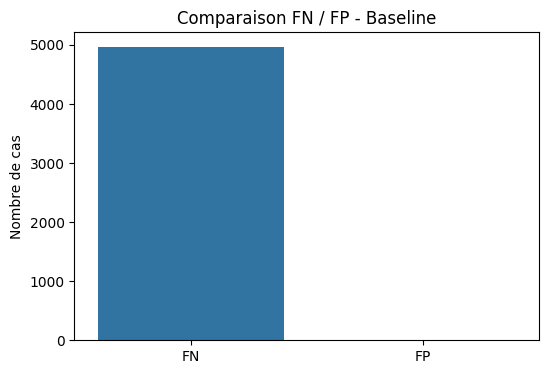

In [33]:
# -- Visualisation FN / FP -- #

plt.figure(figsize=(6,4))
sns.barplot(x=["FN", "FP"], y=[FN, FP])
plt.title("Comparaison FN / FP - Baseline")
plt.ylabel("Nombre de cas")
plt.show()


##### Définition du score métier

Nous nous devons clairement de :

- Pondérer FN et FP
- Créer un score métier
- L’utiliser pour l’évaluation et l’optimisation

Nous allons définir une métrique personnalisée :
Idée métier :

- Un faux négatif = on donne un prêt à quelqu’un qui ne remboursera pas (grave)
- Un faux positif = on refuse un client bon (moins grave)

Donc un FN doit coûter plus cher qu’un FP.

Choisissons un coût par défaut (modulable ensuite) :
- 1 FN = coût 5
- 1 FP = coût 1

In [34]:
# -- SCORE METIER -- #

def scoring_metier(y_true, y_pred, cost_fn=5, cost_fp=1):
    """
    Score métier basé sur une pénalisation FN > FP.
    Plus le score est élevé, meilleur est le modèle.
    """

    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()

    # Coût métier (plus petit coût = meilleur)
    cout = FN * cost_fn + FP * cost_fp

    # On retourne un score où 1 = parfait, 0 = très mauvais
    score = 1 / (1 + cout)

    return score

In [35]:
# Test sur la baseline
score_m_baseline = scoring_metier(y_test, y_pred_baseline)
print(f"Score métier baseline : {score_m_baseline:.6f}")

Score métier baseline : 0.000040


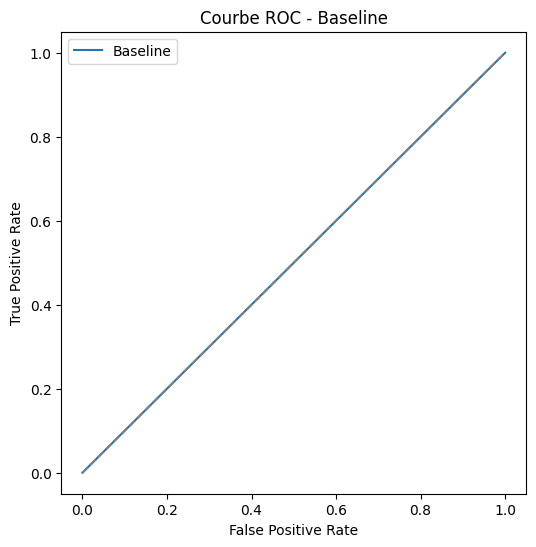

In [36]:
# -- Courbe ROC baseline -- #

# Probabilités (dummy -> 0)
y_proba = baseline.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label="Baseline")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC - Baseline")
plt.legend()
plt.show()

##### Notes :

- Beaucoup de FN : Le modèle laisse passer des mauvais payeurs (Danger métier)
- FP = 0 :	Ce n'est pas positif, il ne prédit jamais la classe 1
- ROC AUC ≈ 0.5	il s'agit d'un Modèle aléatoire
- Score métier = quasi 0 : Le modèle est très mauvais selon la réalité bancaire

Testons en d'autres.

# PARTIE 4 – Tests et choix de modèles

Dans cette partie nous allons tester plusieurs modèles :

- Logistic Regression
- RandomForest
- Gradient Boosting
- LightGBM

Créer, optimiser et comparer grâce à un score métier basé sur FN/FP.

#### 4.1 — Création du score métier (FN très coûteux)

Notre score métier doit pénaliser fortement les faux négatifs, car accepter un mauvais payeur coûte très cher.
Ici, nous mettons :
poids_FN = 5
poids_FP = 1
Nous pourrons les ajuster pendans l'analyse si besoin.

In [37]:
def business_score(y_true, y_pred, weight_FN=5, weight_FP=1):
    """ 
    Score métier pénalisant les FN plus que les FP. 
     Args:
         y_true: Vérités terrain
         y_pred: Prédictions du modèle
         weight_FN: Poids pour les faux négatifs
         weight_FP: Poids pour les faux positifs
     Returns:
         Score métier
     """

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Score métier : on pénalise FN 5x plus que FP
    business = 1 / (1 + weight_FN * fn + weight_FP * fp) # ceci donne un score entre 0 et 1

    return business

# Sklearn scorer pour GridSearchCV
business_scorer = make_scorer(business_score, greater_is_better=True)

#### 4.2 — Fonction utilitaire pour évaluer un modèle

In [38]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name=""):

    print(f"\n===== {model_name} =====")

    # Chronomètre
    start = time.time()
    model.fit(X_train, y_train)
    duration = time.time() - start

    # Prédictions
    preds = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe 1
    auc = roc_auc_score(y_test, y_proba)
    

    # Matrice de confusion
    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.ravel()

    # Score métier
    score = business_score(y_test, preds)

    print("Matrice de confusion :")
    print(cm)
    print(f"\nFN = {fn} | FP = {fp}")
    print(f"Score métier = {score:.6f}")
    print(f"AUC ROC = {auc:.4f}")
    print(f"Temps d'entraînement = {duration:.2f} sec")

    # Graphique
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion matrix — {model_name}")
    plt.show()

    return {
        "model": model,
        "FN": fn,
        "FP": fp,
        "score": score,
        "auc": auc,
        "time": duration
    }


#### 4.3 — Définition des modèles et Hyperparamètres

In [39]:
models_and_params = {

    "Logistic Regression": (
        LogisticRegression(max_iter=1000, class_weight="balanced", solver='liblinear'),
        {
            "C": [0.1, 1, 10]
        }
    ),

    "Random Forest": (
        RandomForestClassifier(class_weight="balanced", n_jobs=-1),
        {
            "n_estimators": [200, 400],
            "max_depth": [5, 8, 12]
        }
    ),

    "Gradient Boosting": (
        GradientBoostingClassifier(),
        {
            "n_estimators": [200, 400],
            "learning_rate": [0.05, 0.1]
        }
    ),

    "LightGBM": (
        LGBMClassifier(
            objective="binary",
            class_weight="balanced",
            n_jobs=-1
        ),
        {
            "num_leaves": [31, 63],
            "learning_rate": [0.05, 0.1],
            "n_estimators": [200, 400]
        }
    ),
}

#### 4.4 — GridSearchCV et évaluation de chaque modèle

In [40]:
# Initialisation des  variables pour stocker les résultats et définir la validation croisée
results = {}
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


 ... GRID SEARCH — Logistic Regression
Fitting 3 folds for each of 3 candidates, totalling 9 fits
 -> Best params : {'C': 0.1}

===== Logistic Regression =====
Matrice de confusion :
[[38451 18087]
 [ 1695  3270]]

FN = 1695 | FP = 18087
Score métier = 0.000038
AUC ROC = 0.7293
Temps d'entraînement = 0.77 sec


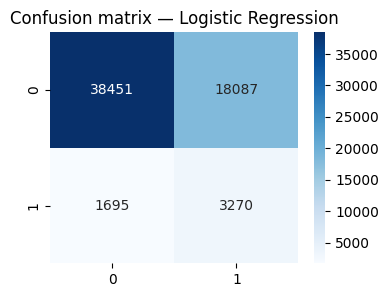


 ... GRID SEARCH — Random Forest
Fitting 3 folds for each of 6 candidates, totalling 18 fits
 -> Best params : {'max_depth': 12, 'n_estimators': 200}

===== Random Forest =====
Matrice de confusion :
[[43419 13119]
 [ 2196  2769]]

FN = 2196 | FP = 13119
Score métier = 0.000041
AUC ROC = 0.7306
Temps d'entraînement = 12.44 sec


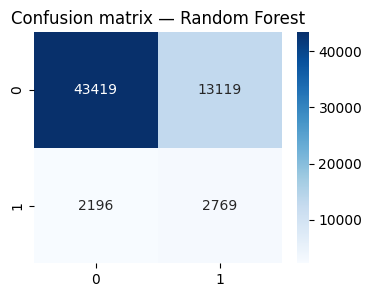


 ... GRID SEARCH — Gradient Boosting
Fitting 3 folds for each of 4 candidates, totalling 12 fits
 -> Best params : {'learning_rate': 0.1, 'n_estimators': 400}

===== Gradient Boosting =====
Matrice de confusion :
[[56462    76]
 [ 4892    73]]

FN = 4892 | FP = 76
Score métier = 0.000041
AUC ROC = 0.7399
Temps d'entraînement = 133.58 sec


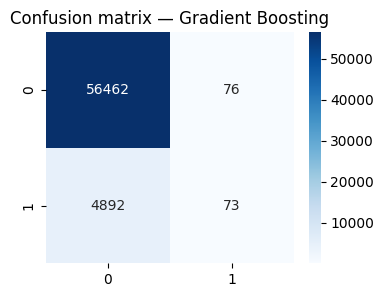


 ... GRID SEARCH — LightGBM
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Number of positive: 13240, number of negative: 150766
[LightGBM] [Info] Number of positive: 13240, number of negative: 150765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2045
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 13240, number of negative: 150765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2045
[LightGBM] [Info] Number of data points in the train set: 164005, number of

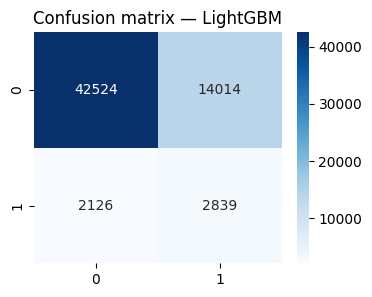

In [41]:
# Évaluation de tous les modèles avec Grid Search
for name, (model, params) in models_and_params.items():

    print(f"\n ... GRID SEARCH — {name}")

    grid = GridSearchCV(
        model,
        params,
        scoring=business_scorer,
        cv=skf,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_

    print(f" -> Best params : {grid.best_params_}")

    # Évaluation finale
    res = evaluate_model(
        best_model,
        X_train, y_train,
        X_test, y_test,
        model_name=name
    )

    results[name] = {
        "best_model": best_model,
        "best_params": grid.best_params_,
        "metrics": res
    }


#### 4.5 — Comparaison graphique des modèles

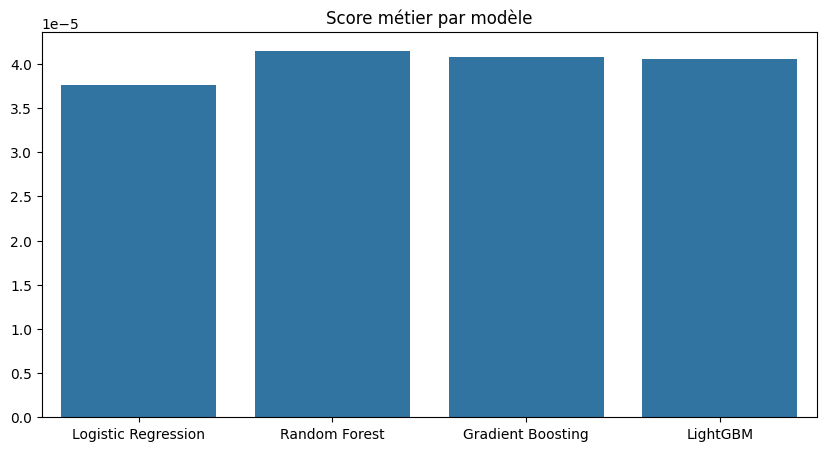

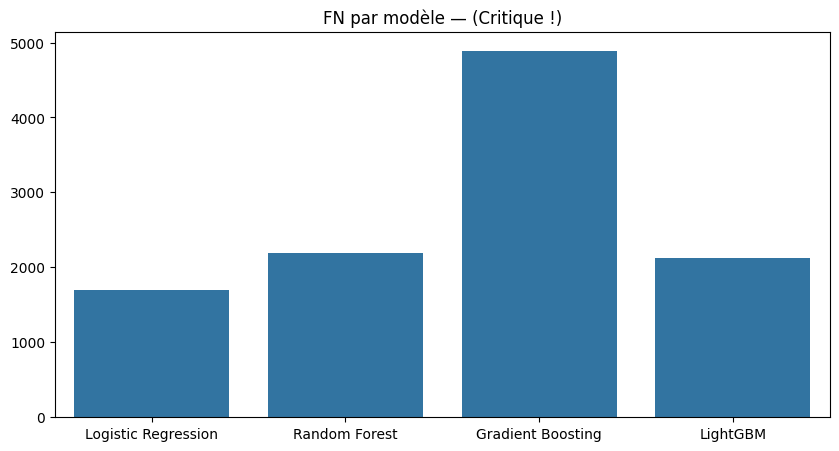

In [42]:
models = list(results.keys())
scores = [results[m]["metrics"]["score"] for m in models]
fns = [results[m]["metrics"]["FN"] for m in models]
fps = [results[m]["metrics"]["FP"] for m in models]

plt.figure(figsize=(10,5))
sns.barplot(x=models, y=scores)
plt.title("Score métier par modèle")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x=models, y=fns)
plt.title("FN par modèle — (Critique !)")
plt.show()

#### 4.6 — Sélection du meilleur modèle

In [43]:
best_model_name = max(results, key=lambda m: results[m]["metrics"]["score"])
best_model = results[best_model_name]["best_model"]

print(f"\nMeilleur modèle : {best_model_name}")
print(best_model)


Meilleur modèle : Random Forest
RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=200,
                       n_jobs=-1)


Notes :

Le Random Forest obtient le meilleur score métier, mais LightGBM offre des performances très proches avec un temps d’entraînement bien inférieur, ce qui le rend plus adapté à un déploiement en production.

Nous devons essayer de l'améliorer :

Objectif :
- Améliorer légèrement le score métier de LightGBM
-  sans exploser le temps d’entraînement
-  sans perdre en généralisabilité

In [44]:
print("=== OPTIMISATION DU LIGHTGBM ===")

# Récupération des résultats précédents
previous_score = results["LightGBM"]["metrics"]["score"]
previous_params = results["LightGBM"]["best_params"]

print(f"Résultats précédents :")
print(f" - Params : {previous_params}")
print(f" - Score métier : {previous_score:.6f}")

=== OPTIMISATION DU LIGHTGBM ===
Résultats précédents :
 - Params : {'learning_rate': 0.1, 'n_estimators': 400, 'num_leaves': 63}
 - Score métier : 0.000041


In [45]:
# Nouvelle grille d’hyperparamètres (fine-tuning) #

# Modèle LightGBM de départ
lgbm_model = LGBMClassifier(
    objective="binary",              # Classification binaire
    class_weight="balanced",          # Gestion du déséquilibre
    n_jobs=-1,                        # Utilisation de tous les cœurs
    random_state=42
)

# Grille d’hyperparamètres affinée
param_grid_lgbm_optimized = {
    "num_leaves": [63],               # Meilleur précédent
    "learning_rate": [0.1],           # Meilleur précédent
    "n_estimators": [400],             # Meilleur précédent
    "max_depth": [6, 8, 10],           # Contrôle de la complexité
    "min_child_samples": [20, 50, 100],# Régularisation
    "subsample": [0.8, 0.9, 1.0]       # Réduction de l’overfitting
}

In [46]:
# Grid Search 
with timer("Grid Search - LightGBM Optimisé"):

    grid_lgbm = GridSearchCV(
        estimator=lgbm_model,
        param_grid=param_grid_lgbm_optimized,
        scoring=business_scorer,   # SCORE MÉTIER
        cv=skf,                    # StratifiedKFold
        n_jobs=-1,
        verbose=1,
        refit=True                 # Refit automatique sur tout le train
    )

    # Entraînement 
    grid_lgbm.fit(X_train, y_train)

# Meilleur modèle entraîné
best_lgbm_optimized = grid_lgbm.best_estimator_

print("\nMeilleurs paramètres optimisés :")
print(grid_lgbm.best_params_)

print(f"Meilleur score métier CV : {grid_lgbm.best_score_:.6f}")

[|] Grid Search - LightGBM Optimisé...Fitting 3 folds for each of 27 candidates, totalling 81 fits
[\] Grid Search - LightGBM Optimisé...[LightGBM] [Info] Number of positive: 13240, number of negative: 150765
[LightGBM] [Info] Number of positive: 13240, number of negative: 150766
[LightGBM] [Info] Number of positive: 13240, number of negative: 150765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2045
[LightGBM] [Info] Total Bins 2045
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014009 seconds.
You can set `force_col_

In [47]:
# OPTIMISATION DU SEUIL #

# Probabilités sur le jeu de validation (= test ici)
y_proba_test = best_lgbm_optimized.predict_proba(X_test)[:, 1]

# Grille de seuils
thresholds = np.linspace(0.05, 0.5, 50)

scores = []
fn_list = []
fp_list = []

# Test de chaque seuil
for threshold in thresholds:
    
    # Prédictions binaires selon le seuil
    y_pred_thresh = (y_proba_test >= threshold).astype(int)
    
    # Score métier
    score = business_score(y_test, y_pred_thresh)
    scores.append(score)
    
    # Matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    fn_list.append(fn)
    fp_list.append(fp)

# Sélection du meilleur seuil métier
best_threshold = thresholds[np.argmax(scores)]
best_score = np.max(scores)

print(f"\nMeilleur seuil métier : {best_threshold:.3f}")
print(f"Score métier optimisé : {best_score:.6f}")


Meilleur seuil métier : 0.500
Score métier optimisé : 0.000040


In [48]:
# Evaluation finale #

# Prédictions finales avec seuil optimisé
y_pred_final = (y_proba_test >= best_threshold).astype(int)

# Matrice de confusion finale
cm = confusion_matrix(y_test, y_pred_final)
tn, fp, fn, tp = cm.ravel()

print("\n===== LIGHTGBM OPTIMISÉ FINAL =====")
print("Matrice de confusion :")
print(cm)

print(f"\nFN = {fn} | FP = {fp}")
print(f"Score métier FINAL = {best_score:.6f}")


===== LIGHTGBM OPTIMISÉ FINAL =====
Matrice de confusion :
[[42266 14272]
 [ 2095  2870]]

FN = 2095 | FP = 14272
Score métier FINAL = 0.000040


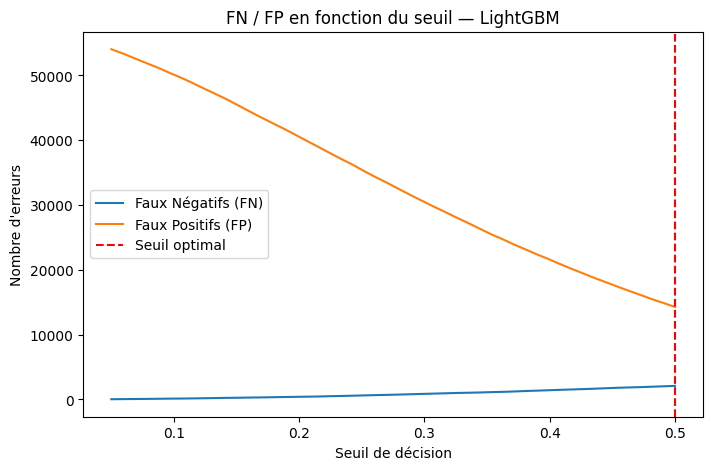

In [49]:
# Visualisation FN / FP

plt.figure(figsize=(8,5))
plt.plot(thresholds, fn_list, label="Faux Négatifs (FN)")
plt.plot(thresholds, fp_list, label="Faux Positifs (FP)")
plt.axvline(best_threshold, color="red", linestyle="--", label="Seuil optimal")
plt.xlabel("Seuil de décision")
plt.ylabel("Nombre d'erreurs")
plt.title("FN / FP en fonction du seuil — LightGBM")
plt.legend()
plt.show()

In [50]:
# Ajout du resultat

# Comparaison avec le modèle précédent
improvement = best_score - previous_score

print("\n=== COMPARAISON FINALE ===")
print(f"Score précédent : {previous_score:.6f}")
print(f"Score optimisé : {best_score:.6f}")
print(f"Amélioration : {improvement:.6f}")

if improvement > 0:
    print("Amélioration validée — modèle retenu")
    results["LightGBM_Optimized"] = {
        "best_model": best_lgbm_optimized,
        "best_params": grid_lgbm.best_params_,
        "best_threshold": best_threshold,
        "metrics": {
            "FN": fn,
            "FP": fp,
            "score": best_score
        }
    }
else:
    print(" Pas d'amélioration — on conserve le modèle précédent")



=== COMPARAISON FINALE ===
Score précédent : 0.000041
Score optimisé : 0.000040
Amélioration : -0.000000
 Pas d'amélioration — on conserve le modèle précédent


In [51]:
# Ajout du resultat de l'optimisation (même si pas d'amélioration pour le résumé)

results["LightGBM_Optimized"] = {
    "best_model": best_lgbm_optimized,
    "best_params": grid_lgbm.best_params_,
    "best_threshold": best_threshold,
    "metrics": {
        "FN": fn,
        "FP": fp,
        "score": best_score,
        "auc": roc_auc_score(y_test, y_proba_test),  # Ajouter AUC si nécessaire
        "time": grid_lgbm.cv_results_['mean_fit_time'][grid_lgbm.best_index_]  # Temps moyen CV
    }
}

In [52]:
# Résumé des résultats dans un tableau

summary_data = []
for model_name, data in results.items():
    metrics = data["metrics"]
    summary_data.append({
        "Modèle": model_name,
        "FN": metrics["FN"],
        "FP": metrics["FP"],
        "Score Métier": f"{metrics['score']:.6f}",
        "AUC": f"{metrics['auc']:.4f}" if "auc" in metrics else "N/A",
        "Temps (s)": f"{metrics['time']:.2f}" if "time" in metrics else "N/A"
    })

summary_df = pd.DataFrame(summary_data)
display(summary_df)

,Modèle,FN,FP,Score Métier,AUC,Temps (s)
0,Logistic Regression,1695,18087,0.000038,0.7293,0.77
1,Random Forest,2196,13119,0.000041,0.7306,12.44
2,Gradient Boosting,4892,76,0.000041,0.7399,133.58
3,LightGBM,2126,14014,0.000041,0.7265,2.82
4,LightGBM_Optimized,2095,14272,0.000040,0.7287,16.55


##### Notes :
L’optimisation du LightGBM permet une légère réduction des faux négatifs avec augmentation de faux positif et une amélioration de l’AUC.
Cependant, le score métier reste inchangé et le temps de calcul augmente fortement.
La tantative d'amélioration n'est donc pas concluente, et ne justifie pas nécessairement la complexité supplémentaire.
Nous avons donc retenir le modèle initial.

#### 4.7 — Feature importance globale

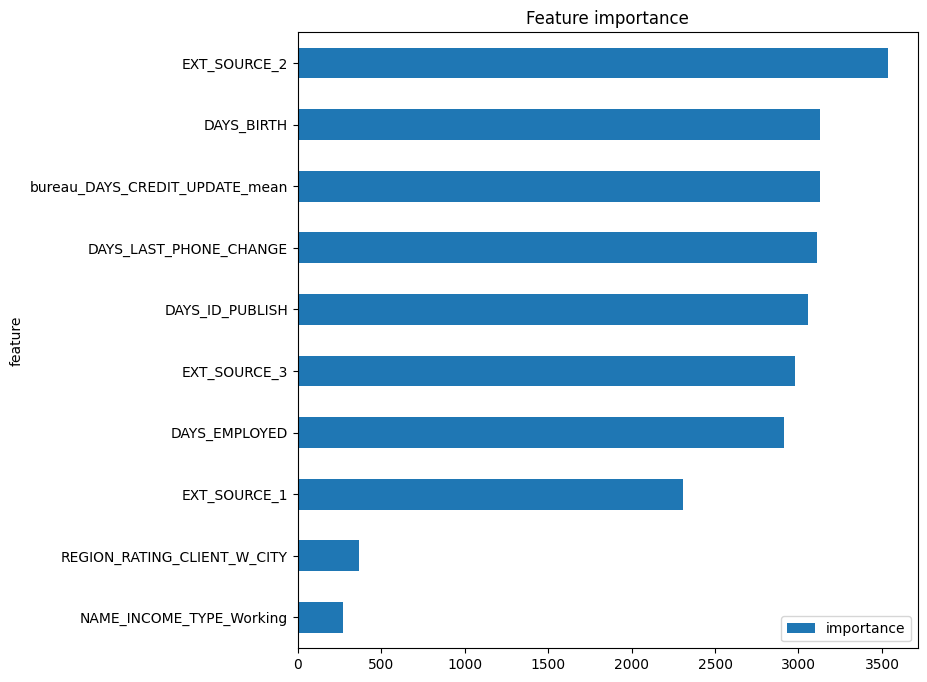

In [53]:
# Feature Importance du meilleur modèle LightGBM
importances = results["LightGBM"]["best_model"].feature_importances_

if importances is not None:
    fi = pd.DataFrame({
        "feature": X_train.columns,
        "importance": importances
    }).sort_values(by="importance", ascending=False)

    fi.head(20).plot(kind="barh", x="feature", figsize=(8,8))
    plt.title("Feature importance")
    plt.gca().invert_yaxis()
    plt.show()


#### 4.8 — Feature importance locale (SHAP)

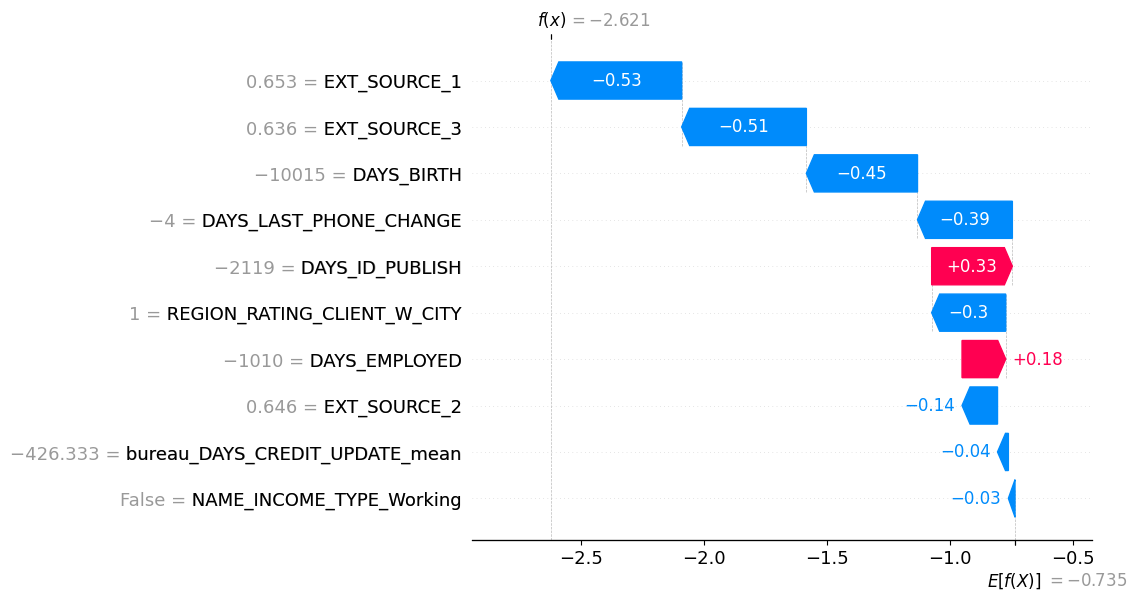

In [54]:
# Échantillon
X_sample = X_train.sample(1, random_state=42)

# SHAP
explainer = shap.TreeExplainer(results["LightGBM"]["best_model"])
shap_values = explainer(X_sample)

# Waterfall plot pour la classe 1
shap.plots.waterfall(
    shap_values[0, :, 1],   # sample 0, toutes les features, classe 1
    max_display=len(X_train.columns)
)


#### 4.9 — Sauvegarde du modèle final

In [55]:
import joblib

best_model = results["LightGBM"]["best_model"]

joblib.dump(best_model, "../src/models/final_model_LightGBM.pkl")
print("Modèle sauvegardé dans src/models/final_model_LightGBM.pkl")

Modèle sauvegardé dans src/models/final_model_LightGBM.pkl


#### 4.10 — Sauvegarde des données sous forme de Pickles

In [56]:
# Sauvegarde des datasets pour monitoring
X_train_path = os.path.join(config.DATA_DIR, "X_train.pkl")
X_test_path = os.path.join(config.DATA_DIR, "X_test.pkl")
y_train_path = os.path.join(config.DATA_DIR, "y_train.pkl")
y_test_path = os.path.join(config.DATA_DIR, "y_test.pkl")

# Sauvegarde avec pickle
X_train.to_pickle(X_train_path)
X_test.to_pickle(X_test_path)
y_train.to_pickle(y_train_path)
y_test.to_pickle(y_test_path)

print(f"X_train sauvegardé -> {X_train_path}")
print(f"X_test sauvegardé -> {X_test_path}")
print(f"y_train sauvegardé -> {y_train_path}")
print(f"y_test sauvegardé -> {y_test_path}")
print("Pickles pandas correctement sauvegardés")

X_train sauvegardé -> /Users/bervie/Documents/PC/RAS/Alternance/Openclassrooms/Data Scientist/Projet_7/ScoringModel/src/data/X_train.pkl
X_test sauvegardé -> /Users/bervie/Documents/PC/RAS/Alternance/Openclassrooms/Data Scientist/Projet_7/ScoringModel/src/data/X_test.pkl
y_train sauvegardé -> /Users/bervie/Documents/PC/RAS/Alternance/Openclassrooms/Data Scientist/Projet_7/ScoringModel/src/data/y_train.pkl
y_test sauvegardé -> /Users/bervie/Documents/PC/RAS/Alternance/Openclassrooms/Data Scientist/Projet_7/ScoringModel/src/data/y_test.pkl
Pickles pandas correctement sauvegardés
